# LSTM

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from r_data import *
from r_model import *
from r_result import *


In [2]:
#cnt
COUNT = 1
global Cnt
Cnt = 1
#PARAMETER
INPUT_SIZE      = 1                                                 # the number of input data feature
NUM_LAYERS      = 1                                                 # Staked RNN
HIDDEN_SIZE     = 8                                                 # hidden layer 8
NUM_CLASSES     = 1                                                 # the number of output data feature
SPLIT           = 200                                               # data split
SEQ_LEN         = 10                                                 # sequence length
BATCH_SIZE      = 20                                                # batch size
CRITERION       = nn.MSELoss()                                      # BinaryCrossEntropy
LEARNING_RATE   = 1e-3                                              # learning rate
NUM_EPOCHS      = 201                                               # epoch
SAMPLE_NUM      = 5
K               = 20

In [3]:
df = pd.read_table(f'C:/Users/DCLAB/Desktop/the_final_output/output_{COUNT}.csv', sep=',')
df = df.fillna(0)
df.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block","Received_Power","Realized_Power"]
df = df.drop(['sequence'], axis=1)
df = df.drop(['distance'], axis=1)
df = df.drop(['inter_x'], axis=1)
df = df.drop(['inter_y'], axis=1)
df = df.drop(['block_x'], axis=1)
df = df.drop(['block_y'], axis=1)
df = df.drop(['Received_Power'], axis=1)
df = df.astype('float')

# GPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')
device = torch.device("cpu")


cuda:0 is available.


In [4]:
a_X = abs(df[["Realized_Power"]].values)
a_y = abs(df["Realized_Power"].values) # target 1

# Meta learning DATASET

### random

In [5]:
class lstm_Task():
		def __init__(self, sample_num, seq_len):
				self.sample_num = sample_num
				self.seq_len		= seq_len

		def random_Train_dataset(self, seq_len, split, batch_size):
				RAND = np.random.randint(low=1, high=160)
				rt = pd.read_table(f'C:/Users/DCLAB/Desktop/the_final_output/output_{RAND}.csv', sep=',')
				rt = rt.fillna(0)
				rl=rt[['Realized_Power']]
				scaler_ = MinMaxScaler()
				scaler_.fit(rl)
				transformed_X = scaler_.transform(rl) ## fit에서 만들어진 함수를 실제로 데이터에 적용
				rt['Realized_Power']=transformed_X
				rt.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block","Received_Power","Realized_Power"]
				rt = rt.drop(['sequence'], axis=1)
				rt = rt.drop(['distance'], axis=1)
				rt = rt.drop(['inter_x'], axis=1)
				rt = rt.drop(['inter_y'], axis=1)
				rt = rt.drop(['block_x'], axis=1)
				rt = rt.drop(['block_y'], axis=1)
				rt = rt.drop(['Received_Power'], axis=1)
				rt = rt.astype('float')

				x = rt[["Realized_Power"]].values
				y = rt["Realized_Power"].values
				
				x_seq, y_seq = self.seq_data_train(x, y, seq_len, split)
				x_train_seq = x_seq
				y_train_seq = y_seq
				train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
				train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
				
				return train_loader
		
		def random_TEST_TRAINSIZE_dataset(self, seq_len, split, batch_size):
				RAND = np.random.randint(low=161, high=180)
				rt = pd.read_table(f'C:/Users/DCLAB/Desktop/the_final_output/output_{RAND}.csv', sep=',')
				RND = np.random.randint(low=1, high=250)
				RANDOM = np.random.randint(low=1, high=100)
				rt = rt.fillna(0)
				rl=rt[['Realized_Power']]
				scaler_ = MinMaxScaler()
				scaler_.fit(rl)
				transformed_X = scaler_.transform(rl) ## fit에서 만들어진 함수를 실제로 데이터에 적용
				rt['Realized_Power']=transformed_X
				rt.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block","Received_Power","Realized_Power"]
				rt = rt.drop(['sequence'], axis=1)
				rt = rt.drop(['distance'], axis=1)
				rt = rt.drop(['inter_x'], axis=1)
				rt = rt.drop(['inter_y'], axis=1)
				rt = rt.drop(['block_x'], axis=1)
				rt = rt.drop(['block_y'], axis=1)
				rt = rt.drop(['Received_Power'], axis=1)
				rt = rt.astype('float')

				x = rt[["Realized_Power"]].values
				y = rt["Realized_Power"].values
				
				x_seq, y_seq = self.seq_data(x, y, seq_len, RND)
				x_train_seq = x_seq
				y_train_seq = y_seq
				train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
				train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
				
				return train_loader, rt["Realized_Power"].values, RND

		def random_Test_dataset(self, seq_len, split, batch_size):
				RAND = np.random.randint(low=181, high=200)
				rt = pd.read_table(f'C:/Users/DCLAB/Desktop/the_final_output/output_{RAND}.csv', sep=',')
				rt = rt.fillna(0)
				rl=rt[['Realized_Power']]
				scaler_ = MinMaxScaler()
				scaler_.fit(rl)
				transformed_X = scaler_.transform(rl) ## fit에서 만들어진 함수를 실제로 데이터에 적용
				rt['Realized_Power']=transformed_X
				rt.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block","Received_Power","Realized_Power"]
				rt = rt.drop(['sequence'], axis=1)
				rt = rt.drop(['distance'], axis=1)
				rt = rt.drop(['inter_x'], axis=1)
				rt = rt.drop(['inter_y'], axis=1)
				rt = rt.drop(['block_x'], axis=1)
				rt = rt.drop(['block_y'], axis=1)
				rt = rt.drop(['Received_Power'], axis=1)
				rt = rt.astype('float')

				x = rt[["Realized_Power"]].values
				y = rt["Realized_Power"].values
				
				x_seq, y_seq = self.seq_data_test(x, y, seq_len, split)
				x_test_seq = x_seq
				y_test_seq = y_seq
				test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
				test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)
				
				return test_loader

		def seq_data_train(self, x, y, seq_len, split): # sequence length
				x_seq = []
				y_seq = []
				RANDOM = np.random.randint(low=1, high=100)
				for i in range(split):
					x_seq.append(x[RANDOM+i:RANDOM+i+seq_len])
					y_seq.append(y[RANDOM+i+seq_len+1])
				
				return torch.FloatTensor(np.array(x_seq)).to(device), torch.FloatTensor(np.array(y_seq)).to(device).view([-1, 1]) 


		def seq_data_test(self, x, y, seq_len, K): # sequence length
				x_seq = []
				y_seq = []
				RANDOM = np.random.randint(low=1, high=100)
				for i in range(K):
					x_seq.append(x[RANDOM+i:RANDOM+i+seq_len])
					y_seq.append(y[RANDOM+i+seq_len+1])
				
				return torch.FloatTensor(np.array(x_seq)).to(device), torch.FloatTensor(np.array(y_seq)).to(device).view([-1, 1]) 


		def seq_data(self, x, y, seq_len, random): # sequence length
				x_seq = []
				y_seq = []
				
				for i in range(K):
					x_seq.append(x[random+i:random+i+seq_len])
					y_seq.append(y[random+i+seq_len+1])
				
				return torch.FloatTensor(np.array(x_seq)).to(device), torch.FloatTensor(np.array(y_seq)).to(device).view([-1, 1]) 

		def random_tasks(self):
			return lstm_Task(SAMPLE_NUM, SEQ_LEN)

LSTM layer 구현

In [6]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=False) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, -1)
        
        ingate = F.sigmoid(ingate)          # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate)  # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate)         # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate)        # 출력 게이트에 시그모이드 적용
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

In [7]:
wt = []
wl = []
class MAMLModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers, device, num_classes):
        super(MAMLModel, self).__init__()
        self.input_size = input_size
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes) #hidden size per length
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size)))
        c0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size)))

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]
       
        for seq in range(x.size(1)) :
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)
        
        out = outs[-1]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    def parameterised(self, x, weights):
        h0 = Variable(torch.Tensor(torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE)))
        c0 = Variable(torch.Tensor(torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE)))

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]
       
        for seq in range(x.size(1)) :
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)

        k = nn.Linear(k, weights[2], weights[3])
        x = torch.sigmoid(k)
        return x


In [8]:
model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device)

model=model.to(device)

In [9]:
for name, param in enumerate(model.parameters()):
    print(name,param.shape)

0 torch.Size([32, 1])
1 torch.Size([32, 8])
2 torch.Size([1, 8])
3 torch.Size([1])


In [10]:
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=20):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = CRITERION
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 10
        self.meta_losses = []
    
    def inner_loop(self, task):
        global Cnt
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
        train_loader = tasks.random_Train_dataset(SEQ_LEN, SPLIT, BATCH_SIZE)
        test_loader = tasks.random_Test_dataset(SEQ_LEN, SPLIT, BATCH_SIZE)

        for step in range(self.inner_steps):
            for i, data in enumerate(train_loader): # batch 
                seq, target = data
                out = model(seq)
                #print(seq, target) = feature, label
                loss = self.criterion(out, target) / self.K
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights,allow_unused=True)
            modified_tuple = tuple(0 if item is None else item for item in grad)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, modified_tuple)]
        
        # sample new data for meta-update and compute loss
        for i, data in enumerate(test_loader): # batch 
                seq, target = data
                out = model(seq)
                #print(seq, target) = feature, label
        loss = self.criterion(out, target) / self.K
        Cnt = Cnt + 1
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            
            # compute meta loss
            meta_loss = 0
            
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.random_tasks()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
                    
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch

            # loss < 0.01 stop
            if epoch_loss / self.plot_every < 0.0001:
                return print("stop iteration: {}", iteration)

            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [11]:
tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
maml = MAML(model, tasks, inner_lr=0.001, meta_lr=0.001)

In [14]:
maml.main_loop(num_iterations=10000)

10/10000. loss: 0.009038332775235174
20/10000. loss: 0.008965527042746543
30/10000. loss: 0.008493798673152923
40/10000. loss: 0.008736640140414238
50/10000. loss: 0.008208636716008185
60/10000. loss: 0.008065883703529836
70/10000. loss: 0.007676682025194169
80/10000. loss: 0.007348132729530335
90/10000. loss: 0.007398862056434155
100/10000. loss: 0.006025066673755646
110/10000. loss: 0.005745146349072457
120/10000. loss: 0.0055282778292894364
130/10000. loss: 0.004440154731273652
140/10000. loss: 0.004614371992647648
150/10000. loss: 0.00424817766994238
160/10000. loss: 0.002989834900945425
170/10000. loss: 0.0035057207942008973
180/10000. loss: 0.003200808316469192
190/10000. loss: 0.0033017226681113245
200/10000. loss: 0.0029201547428965562
210/10000. loss: 0.003212254121899605
220/10000. loss: 0.002605803310871124
230/10000. loss: 0.002856808081269264
240/10000. loss: 0.002773951906710863
250/10000. loss: 0.002796834204345942
260/10000. loss: 0.0025798835046589373
270/10000. loss: 

IndexError: index 308 is out of bounds for axis 0 with size 308

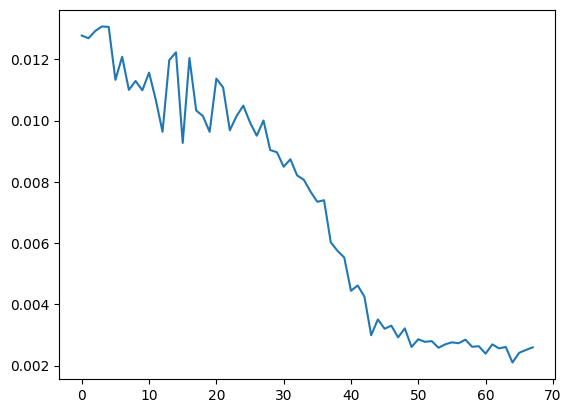

In [15]:
plt.plot(maml.meta_losses)

In [16]:
def loss_on_random_task(initial_model, K, num_steps, optim=torch.optim.Adam):
    """
    trains the model on a random sine task and measures the loss curve.
    
    for each n in num_steps_measured, records the model function after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training

    initial_model.load_state_dict(model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), 0.01)

    # train model on a random task
    for epoch in range(num_steps): # epoch
            running_loss = 0.0  
            tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
            train_loader = tasks.random_Train_dataset(SEQ_LEN, SPLIT, BATCH_SIZE)
            losses = []
            n = len(train_loader)
            
            for i, data in enumerate(train_loader): # batch 
                seq, target = data
                out = model(seq)
                #print(seq, target) = feature, label
                loss = criterion(out, target) / K # y - y_label
                running_loss += loss.item() / n
                losses.append(running_loss)

                model.zero_grad()
                loss.backward()
                optimiser.step()
            
    return losses

In [17]:
def average_losses(initial_model, n_samples, K=10, n_steps=10, optim=torch.optim.Adam):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """
    avg_losses = [0] * K
    for i in range(n_samples):
        losses = loss_on_random_task(initial_model, K, n_steps, optim)
        avg_losses = [l + l_new for l, l_new in zip(avg_losses, losses)]
    avg_losses = [l / n_samples for l in avg_losses]
    
    return avg_losses

In [18]:
def mixed_pretrained(iterations=500):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    pretrain_model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device)
    
    optimiser = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
    train_loader = tasks.random_Test_dataset(SEQ_LEN, SPLIT, BATCH_SIZE) 
    # fit the model
    for i in range(iterations):
        for i, data in enumerate(train_loader): # batch 
            seq, target = data
            out = model(seq)
            #print(seq, target) = feature, label
            loss = criterion(out, target) 
            pretrain_model.zero_grad()
            loss.backward()
            optimiser.step()
        
    return pretrain_model

In [19]:
pretrained_model = mixed_pretrained(100)

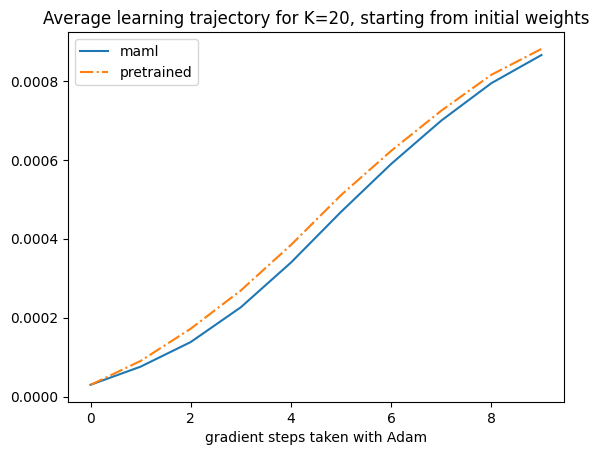

In [20]:
plt.plot(average_losses(maml.model, n_samples=300, K=20), label='maml')
plt.plot(average_losses(pretrained_model, n_samples=300, K=20),'-.', label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=20, starting from initial weights")
plt.xlabel("gradient steps taken with Adam")
plt.show()

In [21]:
def model_functions_at_training(initial_model, X, y, sampled_steps, optim=torch.optim.Adam, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    
    model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device)

    model.load_state_dict(initial_model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()
        tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
        test_loader = tasks.random_Test_dataset(SEQ_LEN, SPLIT, BATCH_SIZE)
        for i, data in enumerate(test_loader): # batch 
            seq, target = data
            # plot the model function
            if step in sampled_steps:
                outputs[step] = model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
    
    return outputs, losses

In [22]:
def plot_sampled_performance(initial_model, model_name, task, X, y, optim=torch.optim.Adam, lr=0.01):
    
    sampled_steps=[1,10,50]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps,
                                                  optim=optim, lr=lr)

    plt.figure(figsize=(15,5))
    x_axis = np.linspace(0, 19, 20)
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(y, '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x_axis, y, label='data')
    
    for step in sampled_steps:
        if step == 1:
            plt.plot(outputs[step], '-.', color=(0.5, 0, 0, 1),
                    label='model after {} steps'.format(step))
        elif step == 10:
            plt.plot(outputs[step], '*-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))
        elif step == 50:
            plt.plot(outputs[step], '--', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))

    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=to

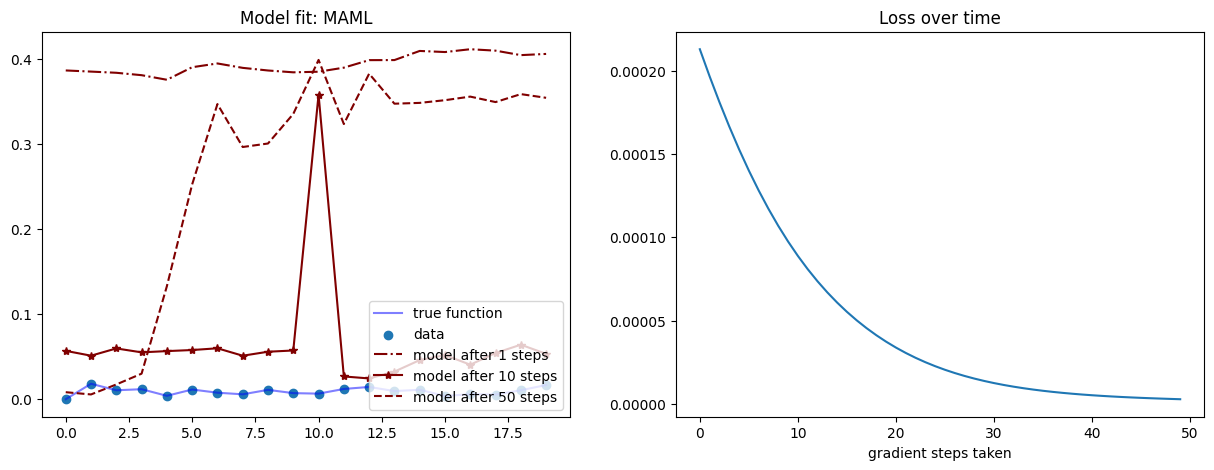

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=torch.float)).detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_24092\2448814919.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(seq, dtype=to

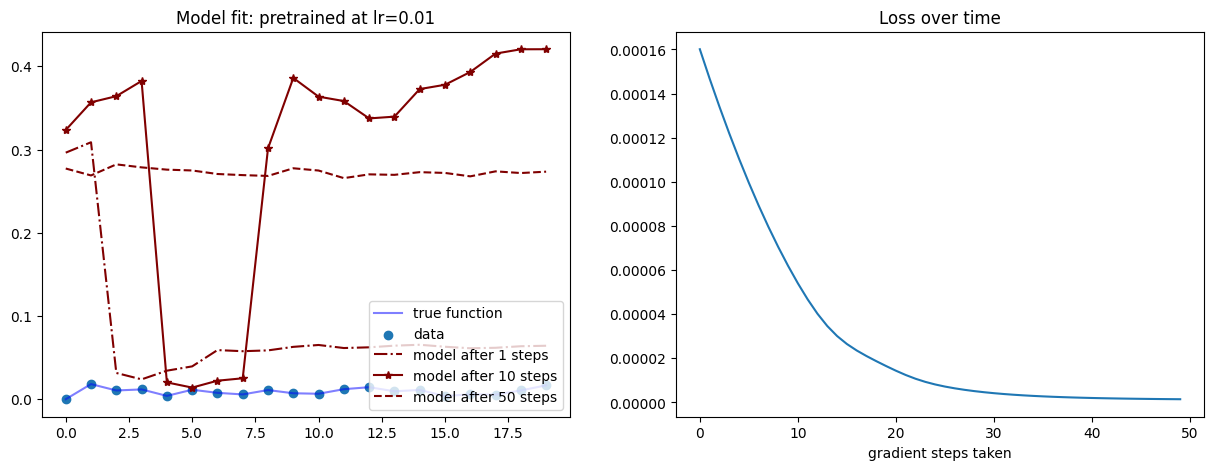

In [23]:
K = 20

tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
test_loader = tasks.random_Test_dataset(SEQ_LEN, SPLIT, BATCH_SIZE)
losses = []
n = len(test_loader)

for i, data in enumerate(test_loader): # batch 
    seq, target = data
    out = model(seq)
    #print(seq, target) = feature, label
    loss = nn.MSELoss() # y - y_label
    losses.append(loss(out, target))

plot_sampled_performance(maml.model, 'MAML', tasks, seq, target)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', tasks, seq, target)

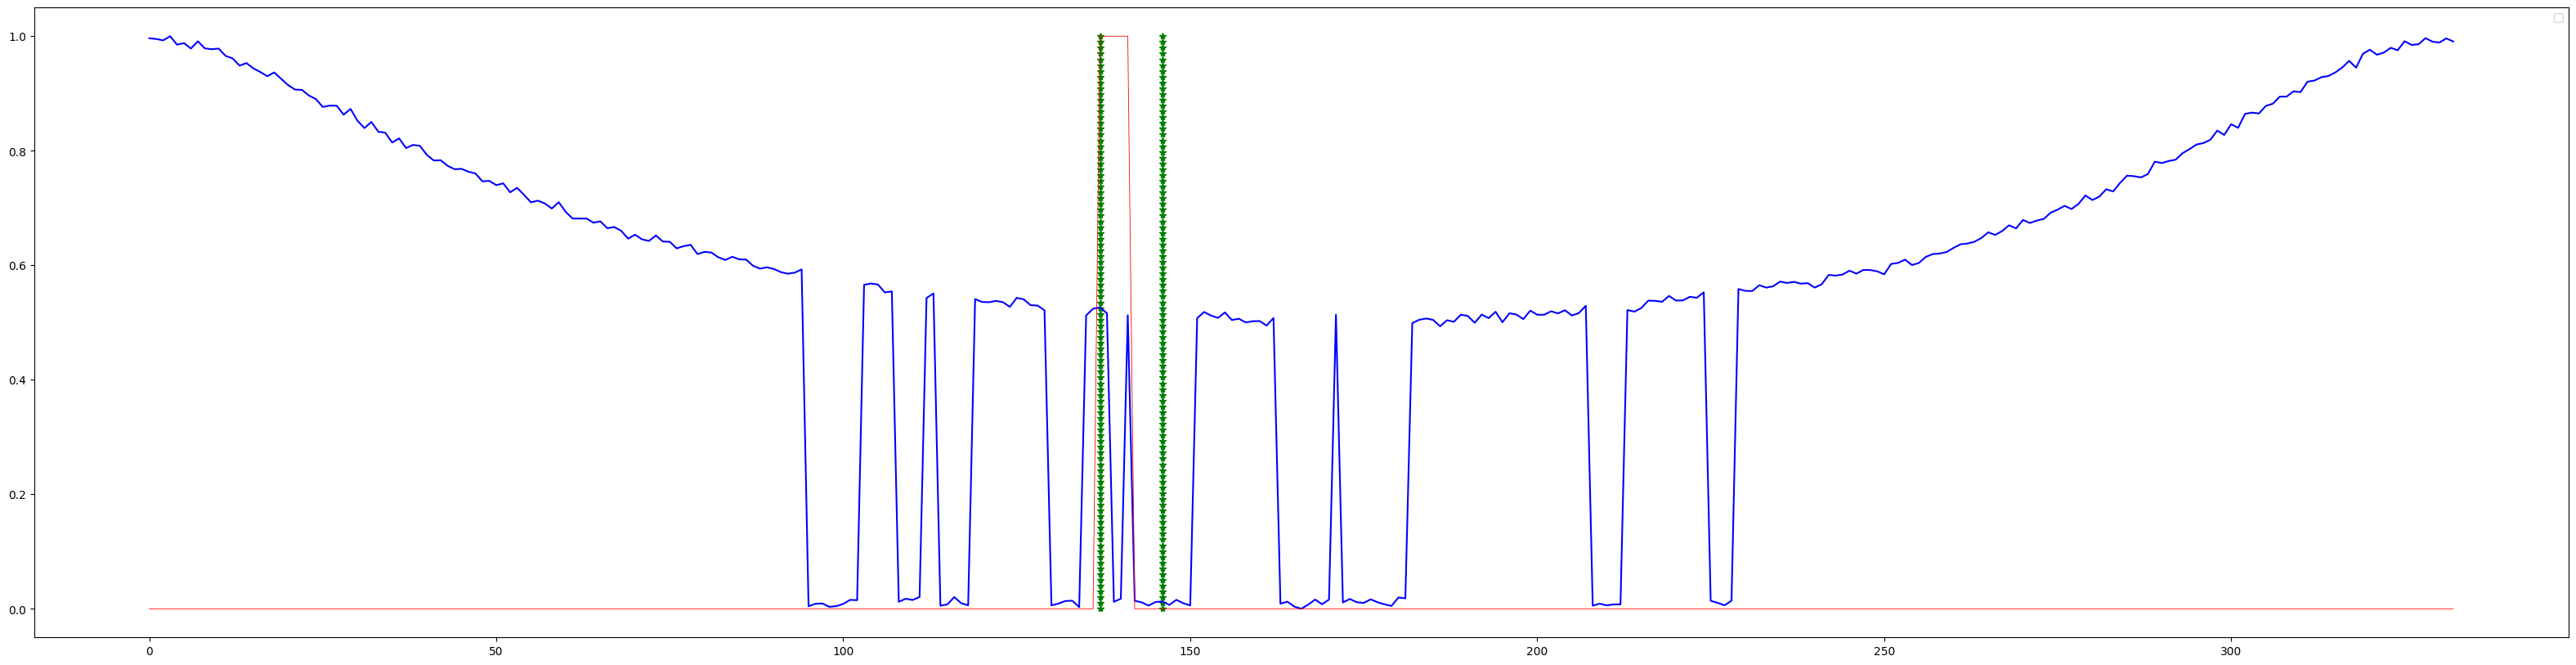

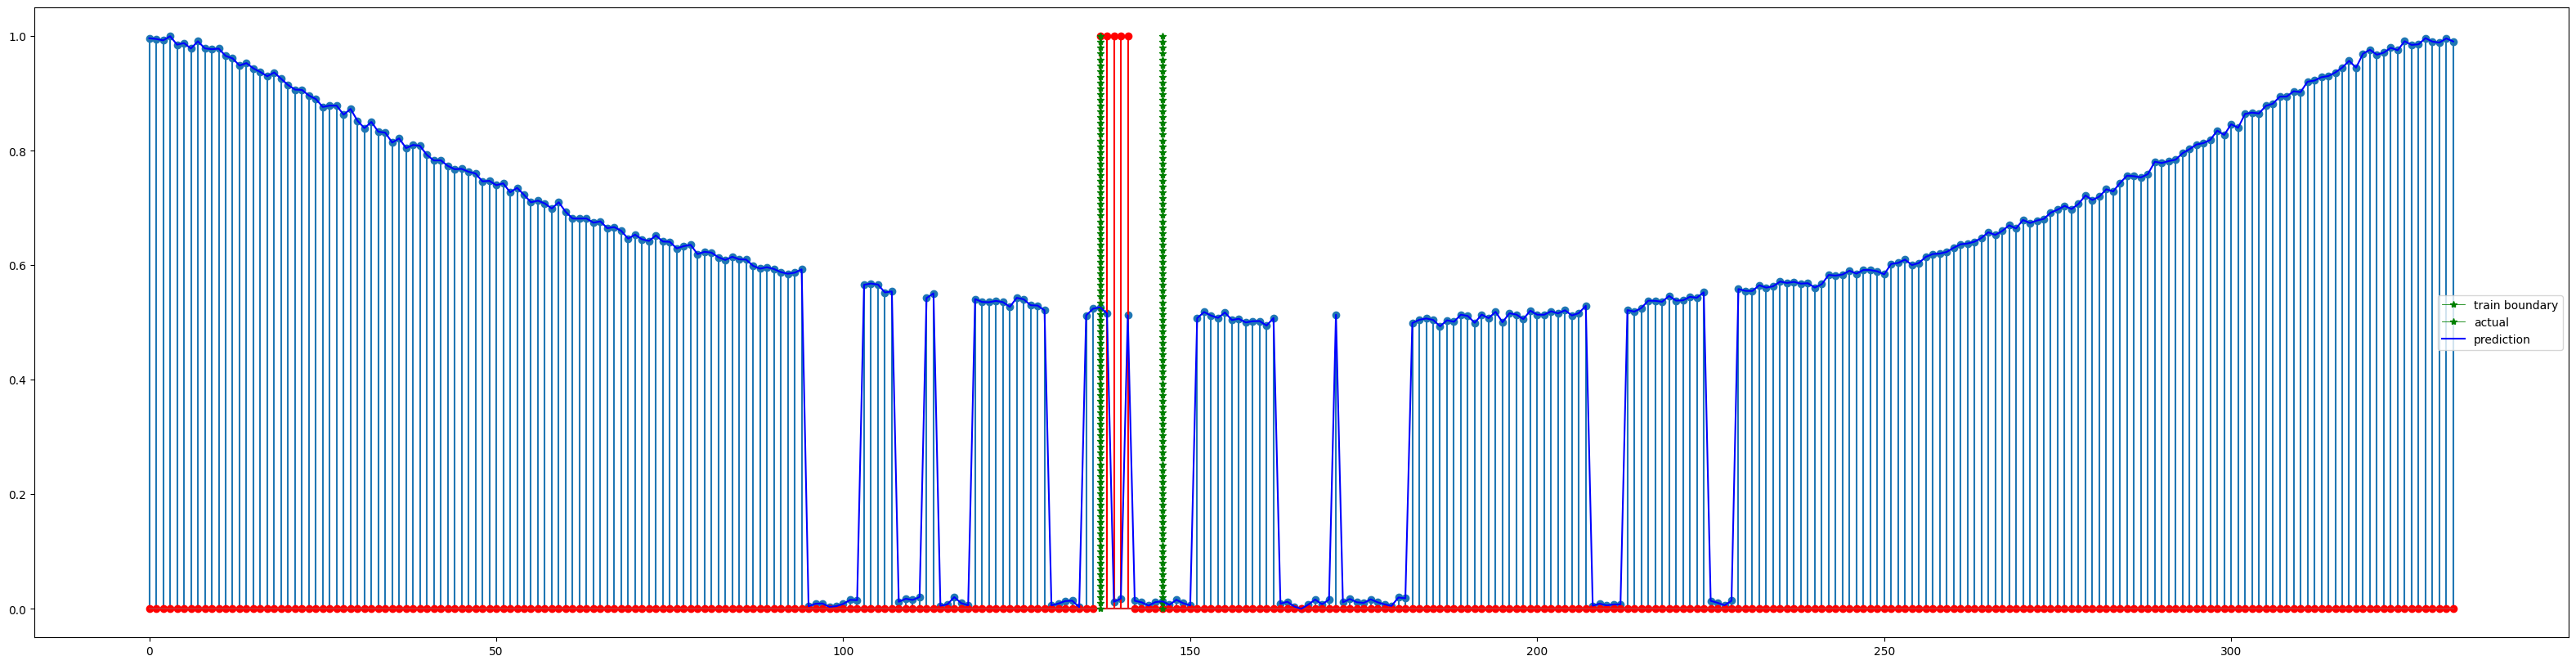

In [164]:
K = 10

tasks = lstm_Task(SAMPLE_NUM, SEQ_LEN)
test_loader, a, rand= tasks.random_TEST_TRAINSIZE_dataset(SEQ_LEN, SPLIT, K)
losses = []
n = len(test_loader)

for i, data in enumerate(test_loader): # batch 
    seq, target = data
    out = maml.model(seq)
    #print(seq, target) = feature, label
    loss = nn.MSELoss() # y - y_label
    losses.append(loss(out, target))


with torch.no_grad():

    test_pred = []
    for data in test_loader:
        seq, target = data # batch data 
        out = model(seq)
        test_pred += out.cpu().numpy().round().tolist()

    #classification 
    #train_pred, test_pred = one_hot_encoding(train_pred, test_pred)

    #acutal = label(y), total = y_pred
    total = test_pred       
    
    #plot
    plt.figure(figsize=(40,10))
    plt.legend(['train boundary','actual','prediction'])
    #signal
    plt.plot(np.ones(100)*(rand-1), np.linspace(0,1,100),'g-*', linewidth=0.6)
    plt.plot(np.ones(100)*(rand+8), np.linspace(0,1,100),'g-*', linewidth=0.6)
    plt.plot(a,'b')

    b = list(np.zeros(rand-1))
    c = list(np.zeros(len(a)-(rand+K-1)))
    to=[]

    for i in range (0, K):
        to.append(total[i][0])
    z = b+to+c

    
    plt.plot(z,'r', linewidth=0.6)

    #stem
    plt.figure(figsize=(40,10))
    plt.stem(a)
    plt.stem(z, 'r')
    plt.plot(np.ones(100)*(rand-1), np.linspace(0,1,100),'g*-', linewidth=0.6)
    plt.plot(np.ones(100)*(rand+8), np.linspace(0,1,100),'g*-', linewidth=0.6)
    plt.plot(a,'b')
    plt.legend(['train boundary','actual','prediction'])
    plt.show()


    # to=[]
    # b = list(np.zeros(len(target)-1))
    
    # plt.figure(figsize=(40,40))
    # for i in range (0, K):
    #     plt.subplot(10, 2, 2*i+1)
    #     plt.stem(seq[i],'b*-')
    #     plt.subplot(10, 2,  2*i+2)
    #     plt.stem(total[i],'ro-')
        
    #plt.plot(to,'b')

